# EDA result 
- created: 10 March 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from os.path import join
import scipy 
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches

In [8]:
def sep_label_position(df):
    df[['Label','Position']] = df['Label'].str.split(';', expand=True) 
    return df

def prep_df(df, is_disyllable):
    if is_disyllable:
        df = sep_label_position(df)
    return df

def custome_reindex(df):
    return df.reindex(["a:", "i:", "u:","e:","E","@","9","o","O"])

def custome_reindex_type2(df):
    return df.reindex(["a:", "i:", "u:","e:",'ɛ:','ə:','œ:','o:','ɔ:', 'ɑ:','ø:','ʊ:'])

def custome_reindex_type3(df):
    return df.reindex(["a:", "i:", "u:","e:",'ɛ:','ɯ:','ɤ:','o:','ɔ:'])

def compute_formant_rmse(formant_df, dir_path, experiment_num, is_disyllable):
    if is_disyllable:
        formant_rmse = formant_df.groupby(['Label', 'Position']).mean().pivot_table(index=['Label'],columns='Position',values=['F1','F2','F3'],fill_value=0)
        formant_rmse.columns = ['-'.join(col).strip() for col in formant_rmse.columns.values]
    else:
        formant_rmse = formant_df.copy().set_index('Label')

    formant_rmse = custome_reindex(formant_rmse)
    formant_rmse.to_csv(join(dir_path,'formant_rmse_exp'+str(experiment_num)+'.csv'))

def compute_formant_ttest(datapoint_df, dir_path, experiment_num, is_disyllable):
	
    datapoint_prep = datapoint_df.pivot_table(index=['Label'],columns='Target',values=['F1','F2'],fill_value=0)
    datapoint_prep.columns = [(str(col[0])+'-'+str(col[1])).strip() for col in datapoint_prep.columns.values]
    datapoint_prep = prep_df(datapoint_prep.reset_index(), is_disyllable)

    if is_disyllable:
        first_syl = datapoint_prep[datapoint_prep['Position']=='1']
        second_syl = datapoint_prep[datapoint_prep['Position']=='2']

        f_f1 = ttest_ind(first_syl['F1-0'], first_syl['F1-1'])
        f_f2 = ttest_ind(first_syl['F2-0'], first_syl['F2-1'])
        s_f1 = ttest_ind(second_syl['F1-0'], second_syl['F1-1'])
        s_f2 = ttest_ind(second_syl['F2-0'], second_syl['F2-1'])

        ttest_df = pd.DataFrame({'result':['t-test','p-value'], 
                                 '1F1':[f_f1[0], f_f1[1]],
                                 '1F2':[f_f2[0], f_f2[1]],
                                 '2F1':[s_f1[0], s_f1[1]],
                                 '2F2':[s_f2[0], s_f2[1]]})
    else:

        f_f1 = ttest_ind(datapoint_prep['F1-0'], datapoint_prep['F1-1'])
        f_f2 = ttest_ind(datapoint_prep['F2-0'], datapoint_prep['F2-1'])

        ttest_df = pd.DataFrame({'result':['t-test','p-value'], 
                                 '1F1':[f_f1[0], f_f1[1]],
                                 '1F2':[f_f2[0], f_f2[1]]})

    ttest_df.to_csv(join(dir_path,'ttest_exp'+str(experiment_num)+'.csv'))

def set_datapoint_index(df):
    df_temp = df.copy()
    df_temp['Label_idx'] = df_temp['Label']
    return df_temp.set_index('Label_idx')

def plot_formant_chart(df, reindex_fn, dir_path, is_disyllable, note=None):

    filled_markers = ['o', 'v', "s", "P", "*", "D", "^", "X", "<", "d", "x", "+"]

    actual = reindex_fn(df[df['Target']==1].copy())
    # filled_markers = actual.index
    actual = actual.reset_index()
    estimated = reindex_fn(df[df['Target']==0].copy()).reset_index()

    fig, ax = plt.subplots()

    for idx, data in enumerate(actual.index):
        mark = filled_markers[idx]
        # mark = '${}$'.format(filled_markers[idx])
        # s=150
        # linewidth='0.5'
        ax.scatter(actual['F2'][idx], actual['F1'][idx], marker=mark,  color='red', label=actual['Label'][idx])
        ax.scatter(estimated['F2'][idx], estimated['F1'][idx], marker=mark, color='blue')

    ax.set_xticks(np.arange(400, 2400+1, 200))
    ax.set_yticks(np.arange(100, 800+1, 100))

    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    ax.set_xlabel('F2 [Hz]', fontsize=14)
    ax.set_ylabel('F1 [Hz]', fontsize=14)

    ax.legend()
    ax.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)

    # ax.grid()

    leg = ax.get_legend()
    for idx,_ in enumerate(leg.legendHandles):
        leg.legendHandles[idx].set_color('black')

    red_patch = mpatches.Patch(color='red', label='Target')
    blue_patch = mpatches.Patch(color='blue', label='Estimated')
    legend1 = ax.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.gca().add_artist(leg)
    plt.gcf().set_size_inches(7,5)

    syllable_type = 'disyllable' if is_disyllable else 'monosyllable'

    if note and is_disyllable:
        ax.set_title('Formant Chart of '+note+' ['+syllable_type+']')
        filename = 'formant_chart_'+syllable_type+' '+note
    else:
        ax.set_title('Formant Chart of ['+syllable_type+']')
        filename = 'formant_chart_'+syllable_type

    for file_type in ['.png','.pdf']:
        plt.savefig(join(dir_path, filename+file_type), dpi=300, bbox_extra_artists=(leg,legend1), bbox_inches='tight')

    plt.clf()


def change_label_set_1(datapoint_df):
    datapoint_df.at['E', 'Label']= 'ɛ:' 
    datapoint_df.at['O', 'Label']= 'ɔ:'
    datapoint_df.at['9', 'Label']= 'œ:'
    datapoint_df.at['@', 'Label']= 'ə:'
    datapoint_df.at['o', 'Label']= 'o:'
    datapoint_df.at['a', 'Label']= 'a:'
    datapoint_df.at['i', 'Label']= 'i:'
    datapoint_df.at['e', 'Label']= 'e:'
    datapoint_df.at['u', 'Label']= 'u:'
    datapoint_df.at['A', 'Label']= 'ɑ:'
    datapoint_df.at['2', 'Label']= 'ø:'
    datapoint_df.at['U', 'Label']= 'ʊ:'

    return datapoint_df

def change_label_set_2(datapoint_df):
    datapoint_df.at['E', 'Label']= 'ɛ:' 
    datapoint_df.at['O', 'Label']= 'ɔ:'
    datapoint_df.at['7', 'Label']= 'ɤ:'
    datapoint_df.at['M', 'Label']= 'ɯ:'
    datapoint_df.at['o', 'Label']= 'o:'
    datapoint_df.at['a', 'Label']= 'a:'
    datapoint_df.at['i', 'Label']= 'i:'
    datapoint_df.at['e', 'Label']= 'e:'
    datapoint_df.at['u', 'Label']= 'u:'
    return datapoint_df

def formant_chart(datapoint_df,  dir_path, experiment_num, is_disyllable, label_set):

    datapoint_df = prep_df(datapoint_df, is_disyllable)
    datapoint_df = set_datapoint_index(datapoint_df)

    if label_set == 1:
        datapoint_df = change_label_set_1(datapoint_df) 
    elif label_set == 2: 
        datapoint_df = change_label_set_2(datapoint_df) 

    if is_disyllable:
        datapoint_df = set_datapoint_index(datapoint_df.groupby(['Label','Target','Position']).mean().reset_index())
        first_syl = datapoint_df[datapoint_df['Position']=='1']
        second_syl = datapoint_df[datapoint_df['Position']=='2']
        if label_set == 1:
            plot_formant_chart(first_syl, custome_reindex_type2, dir_path, is_disyllable, note='FirstSyllable')
            plot_formant_chart(second_syl, custome_reindex_type2, dir_path, is_disyllable, note='SecondSyllable')
        elif label_set == 2: 
            plot_formant_chart(first_syl, custome_reindex_type3, dir_path, is_disyllable, note='FirstSyllable')
            plot_formant_chart(second_syl, custome_reindex_type3, dir_path, is_disyllable, note='SecondSyllable')

    else:
        plot_formant_chart(datapoint_df, custome_reindex, dir_path, is_disyllable)

def generate_eval_result(experiment_num, dir_path, is_disyllable, mode='eval', label_set=1, output_path=None):

    if label_set not in [1,2]:
        raise ValueError('Label set {} not valid! [1:eval, 2:predict]'.format(label_set)) 

#     dir_path = 'result/'+mode+'_'+str(experiment_num)+'/formant/' if output_path==None else output_path

    print('[INFO] read data')
    formant_df = pd.read_csv(join(dir_path, 'formant_df.csv'))
    datapoint_df = pd.read_csv(join(dir_path,'data_point.csv'))

    formant_df = prep_df(formant_df, is_disyllable)

    print('[INFO] generate formant chart')
    formant_chart(datapoint_df,  dir_path, experiment_num, is_disyllable, label_set)

In [9]:
generate_eval_result(0, '../../experiment_1/result/predict_0/formant/', True, mode='predict', label_set=2, output_path=None)

[INFO] read data
[INFO] compute formant rmse
[INFO] compute t-test
[INFO] generate formant chart


<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

## Scatter plot formant 

### Plot formant function 

In [122]:
def plot_each_syllable_formant(input_df, position):
    
    syl_df = input_df[input_df['Position'] == str(position)]
    unique_labels = set(syl_df['Label'].copy())
    
    if len(unique_labels) == 9:
        fig, ax = plt.subplots(3,3, figsize=(15,15))
    elif unique_labels == 12:
        fig, ax = plt.subplots(4,3, figsize=(15,15))
    else:
        fig, ax = plt.subplots(5,5, figsize=(15,15))

    colors = ['blue', 'red']
    target_label = ['estimated','original']

    for idx, label in enumerate(unique_labels):
        axs = ax[idx//3][idx%3]
        for jdx, target in enumerate([0.0, 1.0]):
            df = syl_df[syl_df['Target'] == target]
            axs.scatter(df[df['Label'] == label]['F2'], df[df['Label'] == label]['F1'], c=colors[jdx], label=target_label[jdx])
        axs.title.set_text(label)
        axs.set_xticks(np.arange(400, 2400+1, 200))
        axs.set_yticks(np.arange(100, 800+1, 100))
        axs.set_xlabel('F2')
        axs.set_ylabel('F1')
        axs.invert_xaxis()
        axs.invert_yaxis()
        axs.legend()

### Load data 

In [128]:
datapoint_df = pd.read_csv(join('../../experiment_1/result/predict_3/formant/','data_point.csv'))
datapoint_df_ori = datapoint_df.copy()
datapoint_df = prep_df(datapoint_df, True)
datapoint_df = set_datapoint_index(datapoint_df)
datapoint_df = change_label_set_2(datapoint_df).reset_index().drop(['Label_idx'], axis=1)
datapoint_df.head()

,Label,F1,F2,Target,Position
0,a:,777.945355,1283.831934,1,1
1,i:,312.511901,2248.161735,1,2
2,a:,952.606510,1364.704679,1,1
3,u:,384.688563,625.279456,1,2
4,a:,837.362394,1537.296937,1,1


### First Syllable 

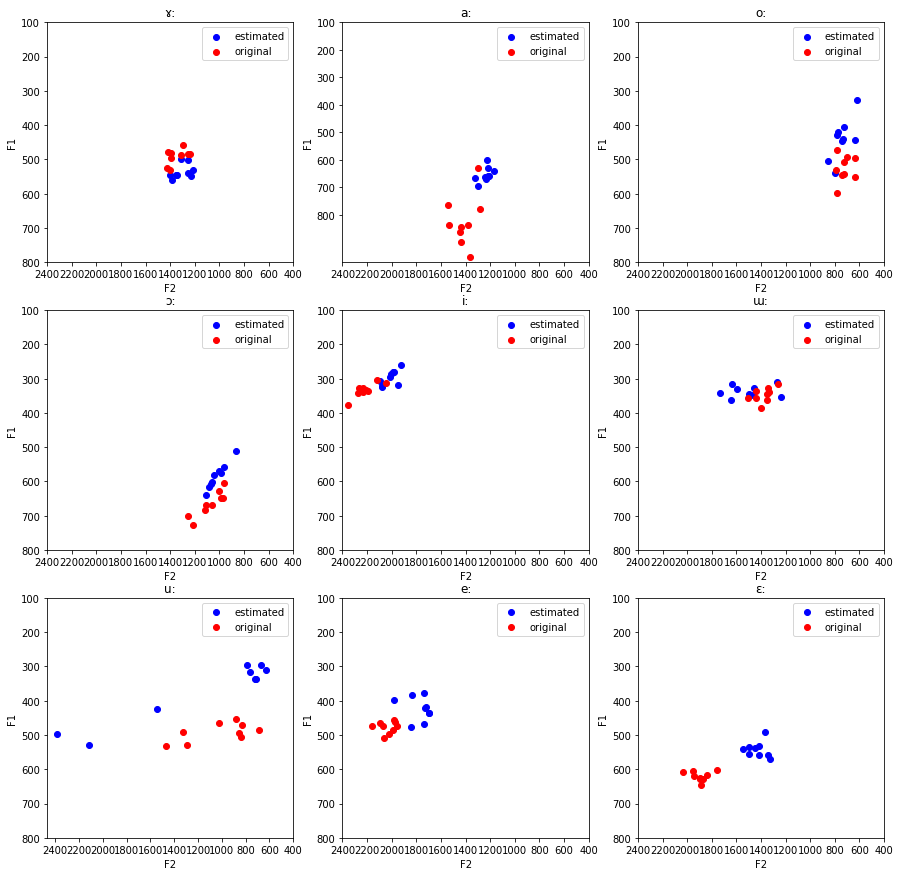

In [129]:
plot_each_syllable_formant(datapoint_df, 1)

### Second Syllable 

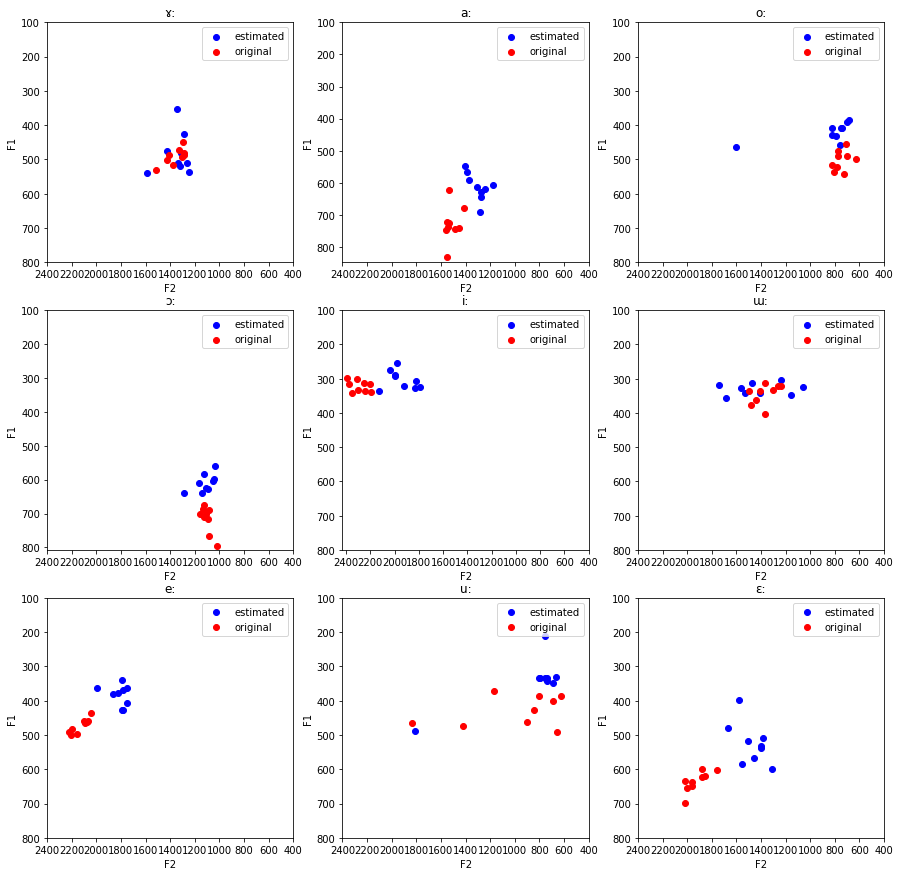

In [130]:
plot_each_syllable_formant(datapoint_df, 2)

### Inspected 

In [68]:
datapoint_df_ori[(datapoint_df_ori['Label'] == 'u;2') & (datapoint_df_ori['F2'] >1600)]

,Label,F1,F2,Target
133,u;2,465.553019,1837.674168,1


In [70]:
datapoint_df_ori.loc[132] #อออู

Label         O;1
F1         649.47
F2        973.633
Target          1
Name: 132, dtype: object

In [71]:
datapoint_df_ori[(datapoint_df_ori['Label'] == 'u;1') & (datapoint_df_ori['F2'] >1200)]

,Label,F1,F2,Target
32,u;1,528.731838,1289.681875,1
36,u;1,533.334952,1469.926523,1
38,u;1,491.599627,1325.481332,1


In [120]:
datapoint_df_ori['E'] = 'e'

In [121]:
datapoint_df_ori

,Label,F1,F2,Target,E
0,a;1,777.945355,1283.831934,1,e
1,i;2,312.511901,2248.161735,1,e
2,a;1,952.606510,1364.704679,1,e
3,u;2,384.688563,625.279456,1,e
4,a;1,837.362394,1537.296937,1,e
...,...,...,...,...,...
319,7;2,449.300415,1228.140407,0,e
320,o;1,353.477319,645.658658,0,e
321,o;2,419.883546,661.097721,0,e
322,O;1,569.319600,1009.126439,0,e
